In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as soup
import requests
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
import csv
import datetime as dt
import urllib
from urllib import error

C:\Users\HPHP\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# 1. Data Extraction - Downloading All Historical Data Files

In [3]:
regions = ["Alaska","Caribbean","Florida","Great_Lakes","Gulf_of_Mexico","Hawaiian_Islands","Northeast_USA","Northwest_USA","South_Pacific","Southeast_USA","Southwest_USA","Western_Atlantic"]

In [4]:
stations = []
for region in regions:
    url = 'https://www.ndbc.noaa.gov/mobile/region.php?reg='+region
    try:
        res = requests.get(url)
        res.raise_for_status()
        regionSoup = soup(res.text,'html.parser')
        link_tags = [(link['href'].replace('station.php?station=',''),link.getText()) for link in regionSoup.select("a[href*=station=]")]
        stations.extend(link_tags)

    except:
        print("Region '"+ region +"' Not Found")

In [5]:
len(stations)

885

In [6]:
df_stations = pd.DataFrame(stations,columns=['StationID','StationName'])
df_stations.head()
df_stations.shape

,StationID,StationName
0,46001,46001 - WESTERN GULF OF ALASKA - 175NM SE of ...
1,46004,46004 - Middle Nomad
2,46035,46035 - CENTRAL BERING SEA - 310 NM North of A...
3,46060,46060 - WEST ORCA BAY - 8NM NW of Hinchinbrook...
4,46061,46061 - Seal Rocks - Between Montague and Hinc...


(885, 2)

In [7]:
# Checking for duplicate Stations
df_stations.shape[0]-df_stations['StationID'].nunique()

174

There are common stations in different regions. Let's remove these duplicates.

In [8]:
df_stations.drop_duplicates(subset=['StationID'],inplace=True)
# Verifying whether duplicate Stations were removed
df_stations.shape[0]-df_stations['StationID'].nunique()

0

In [9]:
df_stations.shape

(711, 2)

In [10]:
# Saving the list of stations dataframe to a CSV file
df_stations.to_csv('ListOfStations_MetaData.csv',index=False, header=True)

In [18]:
#Reading stations data from "ListOfStations_MetaData.csv" file
df_stations = pd.read_csv('ListOfStations_MetaData.csv')

In [11]:
import urllib
class historic_data:

    def __init__(self, buoy, year, year_range=None):
        self.buoy = buoy
        self.year = year
        self.year_range = year_range

        link = 'http://www.ndbc.noaa.gov/view_text_file.php?filename='
        link += '{}h{}.txt.gz&dir=data/historical/'.format(buoy, year)
        self.link = link

    def get_stand_meteo(self,link = None):
        '''
        Standard Meteorological Data. Data header was changed in 2007. Thus
        the need for the if statement below.
        '''     
        if(link == None):
            link = self.link + 'stdmet/'
        
        print(link)

        #combine the first five date columns YY MM DD hh and make index
        try:
            df = pd.read_csv(link, header=0, delim_whitespace=True, dtype=object,
            na_values=[99.0])
        except:
            print('Unable to access: ' + link)
            return None


        #2007 and on format
        if df.iloc[0,0] =='#yr':

            df = df.rename(columns={'#YY': 'YY'}) #get rid of hash

            #make the indices
            
            df.drop(0, inplace=True) #first row is units, so drop them
            
            d = df.YY + ' ' + df.MM+ ' ' + df.DD + ' ' + df.hh + ' ' + df.mm
            ind = pd.to_datetime(d, format="%Y %m %d %H %M")

            df.index = ind

            #drop useless columns and rename the ones we want
            df.drop(['YY','MM','DD','hh','mm'], axis=1, inplace=True)
            df.columns = ['WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD',
                'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']


        #before 2006 to 2000
        else:
            #before 2000
            if df.columns[0] == 'YY':
                date_str = df.YY + ' ' + df.MM + ' ' + df.DD + ' ' + df.hh
                ind = pd.to_datetime(date_str,format="%y %m %d %H")
                df.drop(['YY'], axis=1, inplace=True)
            #before 2006 to 2000
            else:
                date_str = df.YYYY + ' ' + df.MM + ' ' + df.DD + ' ' + df.hh
                ind = pd.to_datetime(date_str,format="%Y %m %d %H")
                df.drop(['YYYY'], axis=1, inplace=True)

            df.index = ind
            
            if 'TIDE' not in df.columns:
                df['TIDE'] = np.NAN

            #some data has a minute column. Some doesn't.

            if 'mm' in df.columns:
                df.drop(['MM','DD','hh','mm'], axis=1, inplace=True)
            else:
                df.drop(['MM','DD','hh'], axis=1, inplace=True)


            df.columns = ['WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD',
                'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']


        # all data should be floats
        try:
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.astype('float')
        except:
            print("Unable to convert dataframe to float type")

        return df

    def get_all_stand_meteo(self):
        """
        Retrieves all the standard meterological data. Calls get_stand_meteo.
        It also checks to make sure that the years that were requested are
        available. Data is not available for the same years at all the buoys.
        Returns
        -------
        df : pandas dataframe
            Contains all the data from all the years that were specified
            in year_range.
        """

        start,stop = self.year_range

        #see what is on the NDBC so we only pull the years that are available
        links = []
        for ii in range(start,stop+1):

            base = 'https://www.ndbc.noaa.gov/view_text_file.php?filename='
            end = '.txt.gz&dir=data/historical/stdmet/'
            link = base + str(self.buoy) + 'h' + str(ii) + end

            try:
                print(link)
                urllib.request.urlopen(link)
                links.append(link)

            except:
                print(str(ii) + ' not in records')

        '''#need to also retrieve jan, feb, march, etc.
        month = ['Jan','Feb','Mar','Apr','May','Jun',
            'Jul','Aug','Sep','Oct','Nov','Dec']
        k = [1,2,3,4,5,6,7,8,9,'a','b','c'] #for the links
        for ii in range(len(month)):
            mid = '.txt.gz&dir=data/stdmet/'
            link = base + str(self.buoy) + str(k[ii]) + '2016' + mid + str(month[ii]) +'/'
            try:
                urllib.request.urlopen(link)
                links.append(link)
            except:
                print(str(month[ii]) + '2016' + ' not in records')
                print(link)'''


        # start grabbing some data
        df=pd.DataFrame() #initialize empty df
        
        for L in links:
            new_df = self.get_stand_meteo(link=L)
            df = df.append(new_df)

        return df


In [12]:
rem_stations = df_stations['StationID'].sort_values().values

In [13]:
year = np.NAN
years_range=(2013,2018)
#for station in df_stations['StationID']:
for station in rem_stations:
    hist = historic_data(station,year,years_range)
    data_station = hist.get_all_stand_meteo()
    if(not data_station.empty):
        data_station.to_csv('HistoricalData/HistMetData_'+station+'.csv',index=True,header=True)

https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41002h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=41024h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41029h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=41043h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41043h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41043h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41044h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41044h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41044h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41044h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41044h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41044h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41044h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=41056h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41056h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41056h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41056h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41056h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41064h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=41064h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=41064h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41064h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41064h

https://www.ndbc.noaa.gov/view_text_file.php?filename=41115h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41115h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41115h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41115h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41115h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=41117h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=41117h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=41117h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=41117h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noa

https://www.ndbc.noaa.gov/view_text_file.php?filename=42020h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42020h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42020h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42020h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42020h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42020h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42020h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42022h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42022h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42022h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42060h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42085h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=42085h2014.txt.gz&dir=data/historical/stdmet/


2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44005h2018.txt.gz&dir=data

https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44020h2018.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44034h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=44065h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44065h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44072h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=44072h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=44072h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=44072h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44072h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44072h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44072h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file

https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=44098h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=46011h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46011h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46011h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46011h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46011h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46013h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46013h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46013h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46013h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46013h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=46028h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46028h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46028h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46028h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46028h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46028h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46029h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46029h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46029h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46029h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=46053h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46053h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46053h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46053h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46053h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46053h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46054h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46054h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46054h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46054h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=46072h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46072h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46072h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46072h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46073h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46073h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46073h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46073h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46073h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46073h2018.txt.gz&dir=data

https://www.ndbc.noaa.gov/view_text_file.php?filename=46082h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46082h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46083h2015.txt.gz&dir=data

https://www.ndbc.noaa.gov/view_text_file.php?filename=46092h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46092h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46092h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46097h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46097h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46097h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46097h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46097h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46097h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file

https://www.ndbc.noaa.gov/view_text_file.php?filename=46121h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46125h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file

2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46207h2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46208h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46208h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46208h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46208h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46208h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46208h2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=46211h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file

https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46221h2018.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46237h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46239h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46239h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=46248h2018.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=48400h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=48400h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=48400h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=48400h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=48400h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=48400h2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=51000h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51000h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51000h2015.txt.gz&dir=data

https://www.ndbc.noaa.gov/view_text_file.php?filename=51202h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51202h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51202h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51202h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51202h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51202h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51205h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51205h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51205h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51205h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=51211h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51212h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=51212h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=51212h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=51212h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=51212h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=51212h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51212h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=51213h2013.txt.gz&dir=data/historical/stdmet/


2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=agxc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=agxc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=agxc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=agxc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=agxc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=agxc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ajxa2h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=ajxa2h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=ajxa2h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noa

https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=anvc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=apam2h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=asto3h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=asto3h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=asto3h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=asto3h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=asto3h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=asto3h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=atgm1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=atgm1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=atgm1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=atgm1h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=batn6h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=batn6h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=batn6h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=batn6h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=batn6h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=batn6h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=baxc1h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=baxc1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=baxc1h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file

https://www.ndbc.noaa.gov/view_text_file.php?filename=bgcf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgcf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bgnn4h2014.txt.gz&dir=data/historical/stdmet/


2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bkyf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=blia2h

https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bobf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=brhc3h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=buzm3h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=buzm3h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=buzm3h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=buzm3h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bwsf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bwsf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bwsf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bwsf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bwsf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=bwsf1h2018.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=capl1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=capl1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=carl1h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chao3h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyv2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=chyw1h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=cmti2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cmti2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cmti2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cmti2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cmti2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cmti2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cnbf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cnbf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cnbf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cnbf1h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=cpvm2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpvm2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpvm2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpxc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpxc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpxc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpxc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpxc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpxc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cpxc1h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=cwbf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwbf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwbf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwbf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwbf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwcih2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwcih2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwcih2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=cwcih2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.go

https://www.ndbc.noaa.gov/view_text_file.php?filename=domv2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=domv2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=dpia1h2014.txt.gz&dir=data/historical/stdmet/


2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=einl1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=elfa2h

https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=espp4h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=fila2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fmoa1h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdw1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=frdw1h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=fsnm2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsnm2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsnm2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsti2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsti2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsti2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsti2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsti2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsti2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=fsti2h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=gctf1h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=gctf1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=gctf1h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=gctf1h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=gctf1h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=gctf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=gctf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=gdmm5h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=gdmm5h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grmm4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=grrt2h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=grrt2h2014.txt.gz&dir=data

https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=haxa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=hbyc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noa

2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmra2h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmra2h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmra2h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmra2h2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmsa2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmsa2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmsa2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmsa2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=hmsa2h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=iloh1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iloh1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iloh1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iloh1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iloh1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iosn3h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iosn3h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iosn3h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iosn3h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=iosn3h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=jmla2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmla2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmla2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmla2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmla2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmla2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmpn7h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmpn7h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmpn7h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=jmpn7h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2018.txt.gz&dir=data/historical/stdmet/
Unable to access: https://www.ndbc.noaa.gov/view_text_file.php?filename=kdaa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdlph2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kdlph2014

2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kgryh2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kgulh2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kgulh2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kgulh2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kgulh2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kgulh2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kgulh2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=khhvh2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/vi

2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp58h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp58h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp58h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp58h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp58h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp58h2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp59h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kp59h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/vi

2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kvqth2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kvqth2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kvqth2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=kwhh1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kwhh1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kwhh1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kwhh1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kwhh1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=kwhh1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.g

https://www.ndbc.noaa.gov/view_text_file.php?filename=lbsf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lbsf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lbsf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lbsf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lbsf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lbsf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lbsf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lcll1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lcll1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lcll1h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=ljpc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ljpc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ljpc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ljpc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ljpc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lkwf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lkwf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lkwf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lkwf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lkwf1h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=lopw1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lopw1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lopw1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lopw1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lopw1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lopw1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=lopw1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=loro1h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=loro1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=loro1h

https://www.ndbc.noaa.gov/view_text_file.php?filename=ltjf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltjf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltjf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltjf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltjf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltrm4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltrm4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltrm4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltrm4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ltrm4h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=mbrm4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mbrm4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mbrm4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mcga1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mcga1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mcga1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mcga1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mcga1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mcga1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mcga1h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=mgip4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgip4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mgpt2h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=mkgm4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mkgm4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mlsc1h

https://www.ndbc.noaa.gov/view_text_file.php?filename=mrcp1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mrho1h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=mtkn6h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mtkn6h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mtkn6h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mukf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mukf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mukf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mukf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mukf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mukf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=mukf1h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=nblp1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nblp1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nblp1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nblp1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nblp1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ncdv2h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=ncdv2h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=ncdv2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ncdv2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ncdv2h

2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=nkxa2h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=nkxa2h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=nkxa2h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=nkxa2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nkxa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nkxa2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nkxa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nlnc3h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nlnc3h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noa

https://www.ndbc.noaa.gov/view_text_file.php?filename=ntbc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntbc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntbc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntbc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntbc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntbc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntbc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntkm3h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntkm3h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ntkm3h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=nwwh1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=obgn6h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=obgn6h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=okxc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=olcn6h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=olcn6h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=osgn6h2018.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcbf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcgt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pcgt2h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=pfdc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfdc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pfxc1h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=pkyf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pkyf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pkyf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pkyf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pkyf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pkyf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pkyf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=plsf1h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=plsf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=plsf1h2015.txt.gz&dir=data

https://www.ndbc.noaa.gov/view_text_file.php?filename=poro3h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=poro3h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=poro3h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=poro3h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=poro3h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=poro3h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=poro3h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=port2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=port2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=port2h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prta2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=prur1h2013.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstl1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstn6h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pstn6h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=ptgc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptgc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptgc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptgc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptgc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptgc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptgc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptim4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptim4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=ptim4h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=pvdr1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvdr1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvdr1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvdr1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvdr1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvgf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvgf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvgf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvgf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=pvgf1h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=rckm4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rckm4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rckm4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rcmc1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rcmc1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rcmc1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rcmc1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rcmc1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rcmc1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rcmc1h2013.txt.gz&dir=data/historical/stdmet/


2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=rkxf1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=rkxf1h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=rkxf1h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=rkxf1h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=rkxf1h2018.txt.gz&dir=data/historical/stdmet/
2018 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=rlit2h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=rlit2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rlit2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rlit2h

https://www.ndbc.noaa.gov/view_text_file.php?filename=rsjt2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rsjt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rsjt2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rsjt2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rsjt2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rsjt2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rsjt2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rtat2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rtat2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=rtat2h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=sbeo3h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbeo3h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbeo3h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbeo3h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbio1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbio1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbio1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbio1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbio1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sbio1h2018.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=sdia2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdia2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sdrt2h2014.txt.gz&dir=data/historical/stdmet/


2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=shxa2h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=shxa2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=shxa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=shxa2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=shxa2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sipf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sipf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sipf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sipf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=sipf1h

https://www.ndbc.noaa.gov/view_text_file.php?filename=skta2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=skta2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=skta2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=skta2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=skta2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=skta2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=skta2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=skxa2h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=skxa2h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=skxa2h

https://www.ndbc.noaa.gov/view_text_file.php?filename=spgf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spgf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spgf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spgf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spgf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spgf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spgf1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spll1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spll1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=spll1h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=svnm4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=svnm4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=swla2h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=tbim4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbim4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbim4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbim4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbyf1h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbyf1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbyf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbyf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbyf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tbyf1h

https://www.ndbc.noaa.gov/view_text_file.php?filename=thlo1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=thlo1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=thlo1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=thlo1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=thrf1h2013.txt.gz&dir=data/historical/stdmet/
2013 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=thrf1h2014.txt.gz&dir=data/historical/stdmet/
2014 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=thrf1h2015.txt.gz&dir=data/historical/stdmet/
2015 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=thrf1h2016.txt.gz&dir=data/historical/stdmet/
2016 not in records
https://www.ndbc.noaa.gov/view_text_file.php?filename=thrf1h2017.txt.gz&dir=data/historical/stdmet/
2017 not in records


https://www.ndbc.noaa.gov/view_text_file.php?filename=tokw1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tokw1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tokw1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tokw1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tpaf1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tpaf1h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tpaf1h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tpaf1h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tpaf1h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=tpaf1h2018.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=twco1h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=txpt2h2015.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=vcva2h2017.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wdsv2h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=welm1h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=welm1h2014.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wnem4h2016.txt.gz&dir=data/historical/stdmet/


https://www.ndbc.noaa.gov/view_text_file.php?filename=wycm6h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=wycm6h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2014.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2015.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2016.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2017.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2018.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2013.txt.gz&dir=data/historical/stdmet/
https://www.ndbc.noaa.gov/view_text_file.php?filename=yabp4h2014.txt.gz&dir=data/historical/stdmet/


In [43]:
df_46026_all[['WVHT','DPD','APD','TIDE']] = df_46026_all[['WVHT','DPD','APD','TIDE']].replace(99.00)

In [50]:
df_46026_all.describe()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
count,90537.000000,101216.000000,101213.000000,101220.000000,101220.000000,101220.000000,71844.000000,92540.000000,101119.000000,92386.000000,7667.000000,0.0,101220.0
mean,256.762727,5.496393,6.973845,1.834546,11.301437,7.066290,279.318551,1016.802143,12.517550,12.805379,11.662215,NaN,99.0
std,83.543681,3.066505,3.626072,0.755278,3.240823,1.456324,34.060328,4.454774,1.745395,1.710796,0.901637,NaN,0.0
min,1.000000,0.000000,0.000000,0.000000,3.230000,3.620000,2.000000,986.100000,5.000000,8.000000,9.400000,NaN,99.0
25%,199.000000,3.000000,4.100000,1.270000,9.090000,6.040000,273.000000,1013.900000,11.300000,11.500000,11.100000,NaN,99.0
50%,300.000000,5.100000,6.500000,1.690000,10.810000,6.850000,289.000000,1016.400000,12.500000,12.900000,11.700000,NaN,99.0
75%,316.000000,7.600000,9.400000,2.270000,13.790000,7.850000,301.000000,1019.500000,13.700000,14.000000,12.200000,NaN,99.0
max,360.000000,20.300000,25.000000,7.350000,23.530000,15.610000,359.000000,1035.600000,22.000000,21.500000,14.300000,NaN,99.0


In [93]:
df_timeline = pd.DataFrame(df_46026_all['WVHT'].groupby([df_46026_all.index.year,df_46026_all.index.month]).mean())
df_timeline.head()

WVHT
2010 2  2.545899
     3  2.552773
     4  2.523522
     5  1.844288
     6  2.022167

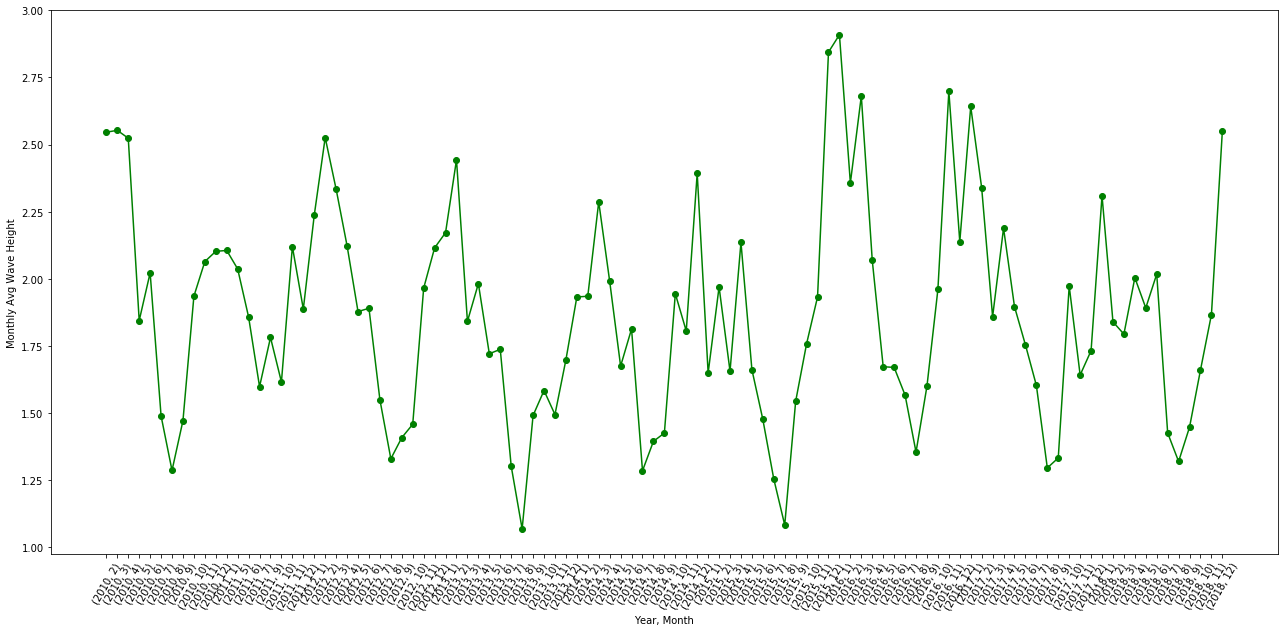

In [100]:
plt.figure(figsize=(22,10))
df_timeline['WVHT'].plot(marker='o', color='g')
plt.xticks(range(len(df_timeline)),df_timeline.index.values, rotation=60)
plt.ylabel('Monthly Avg Wave Height')
plt.xlabel('Year, Month')
plt.show();

In [9]:
hist_46026 = bp.historic_data(46026,2017)
df46026_2017 = hist_46026.get_stand_meteo()

http://www.ndbc.noaa.gov/view_text_file.php?filename=46026h2017.txt.gz&dir=data/historical/stdmet/


# 2. Data Extraction - Currents Data

In [15]:
df = pd.read_csv('ListOfFiles_CurrentsData.csv',skipinitialspace=True)
df.shape
df.head()

(15057, 3)

,FileName,Size,DateModified
0,ca_subSCI_dasuv_201808.nc,58.33 Mbytes,2018-08-10T15:06:17Z
1,ca_subSCI_dasuv_201807.nc,187.6 Mbytes,2018-08-02T03:06:20Z
2,ca_subSCI_dasuv_201806.nc,189.1 Mbytes,2018-07-02T03:06:19Z
3,ca_subSCI_dasuv_201805.nc,193.9 Mbytes,2018-06-02T03:06:22Z
4,ca_subSCI_dasuv_201804.nc,174.9 Mbytes,2018-05-02T03:06:25Z


In [16]:
df['DateObserved'] = df['FileName'].str[-13:-5]
df['Hour'] = df['FileName'].str[-5:-3]

In [17]:
df.head(50)

,FileName,Size,DateModified,DateObserved,Hour
0,ca_subSCI_dasuv_201808.nc,58.33 Mbytes,2018-08-10T15:06:17Z,suv_2018,08
1,ca_subSCI_dasuv_201807.nc,187.6 Mbytes,2018-08-02T03:06:20Z,suv_2018,07
2,ca_subSCI_dasuv_201806.nc,189.1 Mbytes,2018-07-02T03:06:19Z,suv_2018,06
3,ca_subSCI_dasuv_201805.nc,193.9 Mbytes,2018-06-02T03:06:22Z,suv_2018,05
4,ca_subSCI_dasuv_201804.nc,174.9 Mbytes,2018-05-02T03:06:25Z,suv_2018,04
5,ca_subSCI_dasuv_201803.nc,190.7 Mbytes,2018-04-02T03:06:13Z,suv_2018,03
6,ca_subSCI_dasuv_201802.nc,167.1 Mbytes,2018-03-02T04:06:18Z,suv_2018,02
7,ca_subSCI_dasuv_201801.nc,189.1 Mbytes,2018-02-02T04:06:20Z,suv_2018,01
8,ca_subSCI_dasuv_201712.nc,195.4 Mbytes,2018-01-02T04:06:27Z,suv_2017,12
9,ca_subSCI_dasuv_201711.nc,182.8 Mbytes,2017-12-02T04:06:16Z,suv_2017,11


In [18]:
df['DateObserved'] = pd.to_numeric(df['DateObserved'],errors='coerce')
df['Hour'] = pd.to_numeric(df['Hour'],errors='coerce')
df.head(45)

,FileName,Size,DateModified,DateObserved,Hour
0,ca_subSCI_dasuv_201808.nc,58.33 Mbytes,2018-08-10T15:06:17Z,NaN,8
1,ca_subSCI_dasuv_201807.nc,187.6 Mbytes,2018-08-02T03:06:20Z,NaN,7
2,ca_subSCI_dasuv_201806.nc,189.1 Mbytes,2018-07-02T03:06:19Z,NaN,6
3,ca_subSCI_dasuv_201805.nc,193.9 Mbytes,2018-06-02T03:06:22Z,NaN,5
4,ca_subSCI_dasuv_201804.nc,174.9 Mbytes,2018-05-02T03:06:25Z,NaN,4
5,ca_subSCI_dasuv_201803.nc,190.7 Mbytes,2018-04-02T03:06:13Z,NaN,3
6,ca_subSCI_dasuv_201802.nc,167.1 Mbytes,2018-03-02T04:06:18Z,NaN,2
7,ca_subSCI_dasuv_201801.nc,189.1 Mbytes,2018-02-02T04:06:20Z,NaN,1
8,ca_subSCI_dasuv_201712.nc,195.4 Mbytes,2018-01-02T04:06:27Z,NaN,12
9,ca_subSCI_dasuv_201711.nc,182.8 Mbytes,2017-12-02T04:06:16Z,NaN,11


In [19]:
df.shape
df.dropna(subset=['DateObserved'],inplace=True)
df.shape

(15057, 5)

(15014, 5)

In [20]:
df['DateObserved'] = df['DateObserved'].astype(int)
df.head()

,FileName,Size,DateModified,DateObserved,Hour
43,ca_subCA_das_2019040103.nc,31.29 Mbytes,2019-04-01T09:46:33Z,20190401,3
44,ca_subCA_das_2019033121.nc,31.29 Mbytes,2019-04-01T02:45:57Z,20190331,21
45,ca_subCA_das_2019033115.nc,31.29 Mbytes,2019-03-31T23:52:51Z,20190331,15
46,ca_subCA_das_2019033109.nc,31.29 Mbytes,2019-03-31T20:55:50Z,20190331,9
47,ca_subCA_das_2019033103.nc,31.29 Mbytes,2019-03-31T09:46:33Z,20190331,3


In [21]:
df['DateObserved'] = pd.to_datetime(df['DateObserved'],format='%Y%m%d',errors='coerce')

In [22]:
df.head()

,FileName,Size,DateModified,DateObserved,Hour
43,ca_subCA_das_2019040103.nc,31.29 Mbytes,2019-04-01T09:46:33Z,2019-04-01,3
44,ca_subCA_das_2019033121.nc,31.29 Mbytes,2019-04-01T02:45:57Z,2019-03-31,21
45,ca_subCA_das_2019033115.nc,31.29 Mbytes,2019-03-31T23:52:51Z,2019-03-31,15
46,ca_subCA_das_2019033109.nc,31.29 Mbytes,2019-03-31T20:55:50Z,2019-03-31,9
47,ca_subCA_das_2019033103.nc,31.29 Mbytes,2019-03-31T09:46:33Z,2019-03-31,3


In [23]:
df[df['DateObserved'].isna()]

,FileName,Size,DateModified,DateObserved,Hour
9191,ca_subCA_das_2012113121.nc,26.90 Mbytes,2016-11-04T20:45:08Z,NaT,21
9192,ca_subCA_das_2012113115.nc,26.90 Mbytes,2016-11-04T20:45:07Z,NaT,15
9193,ca_subCA_das_2012113109.nc,26.90 Mbytes,2016-11-04T20:45:07Z,NaT,9
9194,ca_subCA_das_2012113103.nc,26.90 Mbytes,2016-11-04T20:45:06Z,NaT,3


### It seems that the above files show date as 2012-11-31, which is invalid date since Nov will have only 30 days. Anyhow these files are from 2012, so we will not be using it in training. Let's drop these.

In [24]:
df.shape
df.dropna(subset=['DateObserved'],inplace=True)
df.shape

(15014, 5)

(15010, 5)

In [25]:
df.sort_values(['DateObserved','Hour'],inplace=True)

In [62]:
df.head()

,FileName,Size,DateModified,DateObserved,Hour
0,ca_subCA_das_2012080103.nc,26.90 Mbytes,2016-11-04T20:39:29Z,2012-08-01,3
1,ca_subCA_das_2012080109.nc,26.90 Mbytes,2016-11-04T20:39:30Z,2012-08-01,9
2,ca_subCA_das_2012080115.nc,26.90 Mbytes,2016-11-04T20:39:31Z,2012-08-01,15
3,ca_subCA_das_2012080121.nc,26.90 Mbytes,2016-11-04T20:39:31Z,2012-08-01,21
4,ca_subCA_das_2012080203.nc,26.90 Mbytes,2016-11-04T20:39:32Z,2012-08-02,3


In [66]:
df['DateObserved'] = pd.to_datetime(df['DateObserved'].astype(str) + ' ' + df['Hour'].astype(str)+':00:00')
df.drop(columns=['Hour'],axis=1,inplace=True)

In [69]:
df.head()

,FileName,Size,DateModified,DateObserved
0,ca_subCA_das_2012080103.nc,26.90 Mbytes,2016-11-04T20:39:29Z,2012-08-01 03:00:00
1,ca_subCA_das_2012080109.nc,26.90 Mbytes,2016-11-04T20:39:30Z,2012-08-01 09:00:00
2,ca_subCA_das_2012080115.nc,26.90 Mbytes,2016-11-04T20:39:31Z,2012-08-01 15:00:00
3,ca_subCA_das_2012080121.nc,26.90 Mbytes,2016-11-04T20:39:31Z,2012-08-01 21:00:00
4,ca_subCA_das_2012080203.nc,26.90 Mbytes,2016-11-04T20:39:32Z,2012-08-02 03:00:00


In [68]:
df.to_csv('Cleaned_ListOfFiles_CurrentsData.csv',index=False)

## Reloading the transformed list of files

In [3]:
df = pd.read_csv('Cleaned_ListOfFiles_CurrentsData.csv',skipinitialspace=True)

## Cleaning the Historical Data Files

In [4]:
df_46042 = pd.read_csv('HistoricalData/HistMetData_46042.csv',skipinitialspace=True)
df_46042.head(1)

,Unnamed: 0,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2012-12-31 23:50:00,317.0,4.4,5.4,2.28,19.05,10.49,302.0,1023.7,11.2,13.0,999.0,NaN,99.0


In [5]:
df_46042.rename(columns={'Unnamed: 0':'Date_Hist'},inplace=True)

In [6]:
df_46042.head(1)

,Date_Hist,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2012-12-31 23:50:00,317.0,4.4,5.4,2.28,19.05,10.49,302.0,1023.7,11.2,13.0,999.0,NaN,99.0


In [7]:
df_46042.replace([99.0,999.0, 9999.0],np.NAN,inplace=True)

In [8]:
df_46042.drop(columns=['VIS','TIDE'],axis=1,inplace=True)

In [9]:
df_46042.isna().any()

Date_Hist    False
WDIR          True
WSPD          True
GST           True
WVHT          True
DPD           True
APD           True
MWD           True
PRES          True
ATMP          True
WTMP          True
DEWP          True
dtype: bool

In [10]:
df_46042.drop(columns=['MWD','DEWP'],axis=1,inplace=True)

In [15]:
df_46042_dropped = df_46042.dropna()
df_46042_dropped.describe()

,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP
count,38712.000000,38712.000000,38712.000000,38712.000000,38712.000000,38712.000000,38712.000000,38712.000000,38712.000000
mean,262.220913,5.725444,7.102606,2.120350,11.830207,7.375190,1016.919338,13.545975,14.148623
std,97.065610,3.128044,3.642075,0.901077,3.128198,1.605017,4.314486,1.952107,1.787770
min,1.000000,0.000000,0.100000,0.560000,3.130000,3.740000,994.400000,5.700000,9.700000
25%,189.000000,3.100000,4.100000,1.470000,9.090000,6.270000,1014.000000,12.300000,12.900000
50%,316.000000,5.400000,6.700000,1.930000,11.430000,7.190000,1016.600000,13.400000,13.900000
75%,329.000000,8.000000,9.700000,2.570000,13.790000,8.200000,1019.700000,14.800000,15.300000
max,360.000000,18.600000,23.000000,8.920000,23.530000,17.610000,1031.700000,21.500000,24.500000


In [16]:
df_46042_dropped.to_csv('Cleaned_HistMetData_46042.csv',index=False)

In [17]:
#df_46042_dropped = pd.read_csv('Cleaned_HistMetData_46042.csv',skipinitialspace=True)

In [18]:
df_46042_dropped.head()

,Date_Hist,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP
0,2012-12-31 23:50:00,317.0,4.4,5.4,2.28,19.05,10.49,1023.7,11.2,13.0
1,2013-01-01 00:50:00,316.0,4.9,5.9,2.23,19.05,10.03,1023.9,11.0,12.9
2,2013-01-01 01:50:00,331.0,4.6,5.8,2.34,19.05,9.86,1024.0,11.0,12.8
3,2013-01-01 02:50:00,342.0,5.2,6.6,2.26,19.05,9.93,1024.2,11.1,12.8
4,2013-01-01 03:50:00,346.0,4.4,5.6,1.92,17.39,9.03,1024.4,11.1,12.7


### Rounding up 'Date_Hist' to nearest hour to match it with "currents data"

In [19]:
df_46042_dropped['Date_Hist'] = pd.to_datetime(df_46042_dropped['Date_Hist']).dt.round('H')

In [20]:
df_46042_dropped.head()

,Date_Hist,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP
0,2013-01-01 00:00:00,317.0,4.4,5.4,2.28,19.05,10.49,1023.7,11.2,13.0
1,2013-01-01 01:00:00,316.0,4.9,5.9,2.23,19.05,10.03,1023.9,11.0,12.9
2,2013-01-01 02:00:00,331.0,4.6,5.8,2.34,19.05,9.86,1024.0,11.0,12.8
3,2013-01-01 03:00:00,342.0,5.2,6.6,2.26,19.05,9.93,1024.2,11.1,12.8
4,2013-01-01 04:00:00,346.0,4.4,5.6,1.92,17.39,9.03,1024.4,11.1,12.7


In [21]:
df[['FileName','DateObserved']].nunique()

FileName        15010
DateObserved     9640
dtype: int64

In [22]:
pd.concat(g for _, g in df.groupby("DateObserved") if len(g) > 1)

,FileName,Size,DateModified,DateObserved
3156,ca_subCA_das_2014100103.nc,26.90 Mbytes,2016-11-04T19:58:15Z,2014-10-01 03:00:00
3157,ca_subCA_bio_2014100103.nc,85.64 Mbytes,2016-11-04T19:31:52Z,2014-10-01 03:00:00
3158,ca_subCA_das_2014100109.nc,26.90 Mbytes,2016-11-04T19:58:15Z,2014-10-01 09:00:00
3159,ca_subCA_bio_2014100109.nc,85.64 Mbytes,2016-11-04T19:31:54Z,2014-10-01 09:00:00
3160,ca_subCA_das_2014100115.nc,26.90 Mbytes,2016-11-04T19:58:16Z,2014-10-01 15:00:00
3161,ca_subCA_bio_2014100115.nc,85.64 Mbytes,2016-11-04T19:31:56Z,2014-10-01 15:00:00
3162,ca_subCA_das_2014100121.nc,26.90 Mbytes,2016-11-04T19:58:17Z,2014-10-01 21:00:00
3163,ca_subCA_bio_2014100121.nc,85.64 Mbytes,2016-11-04T19:31:57Z,2014-10-01 21:00:00
3164,ca_subCA_das_2014100203.nc,26.90 Mbytes,2016-11-04T19:58:18Z,2014-10-02 03:00:00
3165,ca_subCA_bio_2014100203.nc,85.64 Mbytes,2016-11-04T19:31:59Z,2014-10-02 03:00:00


In [23]:
df_right = df[['FileName','DateObserved']].drop_duplicates(subset=['DateObserved'])
df_right.shape

(9640, 2)

In [24]:
df_right.head(1)

,FileName,DateObserved
0,ca_subCA_das_2012080103.nc,2012-08-01 03:00:00


In [27]:
df_right['DateObserved'] = pd.to_datetime(df_right['DateObserved'])
df_right['DateObserved'].dtype

dtype('<M8[ns]')

In [28]:
df2 = pd.merge(df_46042_dropped,df_right,left_on='Date_Hist',right_on='DateObserved',how='left')

In [29]:
df_46042_dropped.shape

(38712, 10)

In [30]:
df2.shape
df2.head()

(38712, 12)

,Date_Hist,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,FileName,DateObserved
0,2013-01-01 00:00:00,317.0,4.4,5.4,2.28,19.05,10.49,1023.7,11.2,13.0,NaN,NaT
1,2013-01-01 01:00:00,316.0,4.9,5.9,2.23,19.05,10.03,1023.9,11.0,12.9,NaN,NaT
2,2013-01-01 02:00:00,331.0,4.6,5.8,2.34,19.05,9.86,1024.0,11.0,12.8,NaN,NaT
3,2013-01-01 03:00:00,342.0,5.2,6.6,2.26,19.05,9.93,1024.2,11.1,12.8,ca_subCA_das_2013010103.nc,2013-01-01 03:00:00
4,2013-01-01 04:00:00,346.0,4.4,5.6,1.92,17.39,9.03,1024.4,11.1,12.7,NaN,NaT


In [31]:
df2.drop(columns=['DateObserved'],axis=1,inplace=True)

In [32]:
df2.shape

(38712, 11)

## Downloading all the NetCDF4 files containing currents data

In [36]:
file_names = list(df2['FileName'].dropna().values)
file_names[:2]

['ca_subCA_das_2013010103.nc', 'ca_subCA_das_2013010109.nc']

In [40]:
file_names.index('ca_subCA_das_2013101015.nc')

1117

In [34]:
len(file_names)

6364

In [ ]:
for file in file_names[1118:]:
    try:
        url = 'http://west.rssoffice.com:8080/thredds/fileServer/roms/CA3km-nowcast/CA/' + file
        urllib.request.urlretrieve(url, 'CurrentsData/'+file)
    except error.HTTPError as e:
        print('The server couldn\'t fulfill the request for',file)
        print('Error code: ', e.code)
    except error.URLError as e:
        print('We failed to reach a server for',file)
        print('Reason: ', e.reason)
    except error.ContentTooShortError as e:
        print('We failed to download the content for',file)
        print('Reason: ', e.reason)

('CurrentsData/ca_subCA_das_2013101021.nc',
 <http.client.HTTPMessage at 0x1ffbeed4438>)

('CurrentsData/ca_subCA_das_2013101109.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013101115.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013101121.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2013101203.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013101209.nc',
 <http.client.HTTPMessage at 0x1ffbeed42b0>)

('CurrentsData/ca_subCA_das_2013101215.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2013101221.nc',
 <http.client.HTTPMessage at 0x1ffbeed4518>)

('CurrentsData/ca_subCA_das_2013101309.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013101315.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2013101321.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013101403.nc',
 <http.client.HTTPMessage at 0x1ffbeed4438>)

('CurrentsData/ca_subCA_das_2013101409.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2013101415.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013101421.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013101509.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2013101515.nc',
 <http.client.HTTPMessage at 0x1ffbeed4ef0>)

('CurrentsData/ca_subCA_das_2013101521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4898>)

('CurrentsData/ca_subCA_das_2013101603.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013101609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4358>)

('CurrentsData/ca_subCA_das_2013101615.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013101621.nc',
 <http.client.HTTPMessage at 0x1ffbeed4240>)

('CurrentsData/ca_subCA_das_2013101703.nc',
 <http.client.HTTPMessage at 0x1ffbeed4048>)

('CurrentsData/ca_subCA_das_2013101709.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013101715.nc',
 <http.client.HTTPMessage at 0x1ffbeed4898>)

('CurrentsData/ca_subCA_das_2013101721.nc',
 <http.client.HTTPMessage at 0x1ffbeed49e8>)

('CurrentsData/ca_subCA_das_2013101803.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b38>)

('CurrentsData/ca_subCA_das_2013101821.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2013101903.nc',
 <http.client.HTTPMessage at 0x1ffbeed47b8>)

('CurrentsData/ca_subCA_das_2013101909.nc',
 <http.client.HTTPMessage at 0x1ffbeed4550>)

('CurrentsData/ca_subCA_das_2013101915.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013101921.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013102003.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2013102009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013102015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013102021.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013102103.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013102109.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013102121.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013102203.nc',
 <http.client.HTTPMessage at 0x1ffbeed4ef0>)

('CurrentsData/ca_subCA_das_2013102209.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a90>)

('CurrentsData/ca_subCA_das_2013102215.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013102221.nc',
 <http.client.HTTPMessage at 0x1ffbeed47f0>)

('CurrentsData/ca_subCA_das_2013102303.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2013102309.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013102315.nc',
 <http.client.HTTPMessage at 0x1ffbeed4908>)

('CurrentsData/ca_subCA_das_2013102321.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2013102403.nc',
 <http.client.HTTPMessage at 0x1ffbeed4898>)

('CurrentsData/ca_subCA_das_2013102409.nc',
 <http.client.HTTPMessage at 0x1ffbeed4dd8>)

('CurrentsData/ca_subCA_das_2013102421.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2013102503.nc',
 <http.client.HTTPMessage at 0x1ffbeed4438>)

('CurrentsData/ca_subCA_das_2013102509.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013102515.nc',
 <http.client.HTTPMessage at 0x1ffbeed4278>)

('CurrentsData/ca_subCA_das_2013102521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b70>)

('CurrentsData/ca_subCA_das_2013102603.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b38>)

('CurrentsData/ca_subCA_das_2013102609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013102621.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013102703.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013102709.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013102715.nc',
 <http.client.HTTPMessage at 0x1ffbeed4978>)

('CurrentsData/ca_subCA_das_2013102721.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013102803.nc',
 <http.client.HTTPMessage at 0x1ffbeed42b0>)

('CurrentsData/ca_subCA_das_2013102815.nc',
 <http.client.HTTPMessage at 0x1ffbeed4048>)

('CurrentsData/ca_subCA_das_2013102821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013102903.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013102909.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2013102915.nc',
 <http.client.HTTPMessage at 0x1ffbeed4748>)

('CurrentsData/ca_subCA_das_2013102921.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013103003.nc',
 <http.client.HTTPMessage at 0x1ffbeed4400>)

('CurrentsData/ca_subCA_das_2013103009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4898>)

('CurrentsData/ca_subCA_das_2013103015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2013103103.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2013103115.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2013103121.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013110103.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2013110109.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013110121.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013110203.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2013110209.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013110215.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d30>)

('CurrentsData/ca_subCA_das_2013110221.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013110303.nc',
 <http.client.HTTPMessage at 0x1ffbeed4240>)

('CurrentsData/ca_subCA_das_2013110309.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013110315.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b70>)

('CurrentsData/ca_subCA_das_2013110321.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2013110403.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013110409.nc',
 <http.client.HTTPMessage at 0x1ffbeed47b8>)

('CurrentsData/ca_subCA_das_2013110415.nc',
 <http.client.HTTPMessage at 0x1ffbeed47f0>)

('CurrentsData/ca_subCA_das_2013110421.nc',
 <http.client.HTTPMessage at 0x1ffbeed42e8>)

('CurrentsData/ca_subCA_das_2013110503.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013110509.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2013110521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a90>)

('CurrentsData/ca_subCA_das_2013110609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4438>)

('CurrentsData/ca_subCA_das_2013110621.nc',
 <http.client.HTTPMessage at 0x1ffbeed4390>)

('CurrentsData/ca_subCA_das_2013110703.nc',
 <http.client.HTTPMessage at 0x1ffbeed4748>)

('CurrentsData/ca_subCA_das_2013110709.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013110715.nc',
 <http.client.HTTPMessage at 0x1ffbeed4358>)

('CurrentsData/ca_subCA_das_2013110721.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2013110809.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013110815.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013110821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013110909.nc',
 <http.client.HTTPMessage at 0x1ffbeed4518>)

('CurrentsData/ca_subCA_das_2013110915.nc',
 <http.client.HTTPMessage at 0x1ffbeed4048>)

('CurrentsData/ca_subCA_das_2013110921.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013111003.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cc0>)

('CurrentsData/ca_subCA_das_2013111009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b38>)

('CurrentsData/ca_subCA_das_2013111015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2013111021.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013111103.nc',
 <http.client.HTTPMessage at 0x1ffbeed4278>)

('CurrentsData/ca_subCA_das_2013111109.nc',
 <http.client.HTTPMessage at 0x1ffbeed47f0>)

('CurrentsData/ca_subCA_das_2013111115.nc',
 <http.client.HTTPMessage at 0x1ffbeed49e8>)

('CurrentsData/ca_subCA_das_2013111121.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2013111203.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2013111209.nc',
 <http.client.HTTPMessage at 0x1ffbeed41d0>)

('CurrentsData/ca_subCA_das_2013111215.nc',
 <http.client.HTTPMessage at 0x1ffbeed47b8>)

('CurrentsData/ca_subCA_das_2013111303.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013111321.nc',
 <http.client.HTTPMessage at 0x1ffbeed4358>)

('CurrentsData/ca_subCA_das_2013111415.nc',
 <http.client.HTTPMessage at 0x1ffbeed49e8>)

('CurrentsData/ca_subCA_das_2013111521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013111603.nc',
 <http.client.HTTPMessage at 0x1ffbeed42e8>)

('CurrentsData/ca_subCA_das_2013111609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013111703.nc',
 <http.client.HTTPMessage at 0x1ffbeed42b0>)

('CurrentsData/ca_subCA_das_2013111709.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013111715.nc',
 <http.client.HTTPMessage at 0x1ffbeed4390>)

('CurrentsData/ca_subCA_das_2013111721.nc',
 <http.client.HTTPMessage at 0x1ffbeed49e8>)

('CurrentsData/ca_subCA_das_2013111803.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a90>)

('CurrentsData/ca_subCA_das_2013111809.nc',
 <http.client.HTTPMessage at 0x1ffbeed4400>)

('CurrentsData/ca_subCA_das_2013111815.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cc0>)

('CurrentsData/ca_subCA_das_2013111821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4dd8>)

('CurrentsData/ca_subCA_das_2013111903.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013111909.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013111915.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013111921.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013112003.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b00>)

('CurrentsData/ca_subCA_das_2013112009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2013112015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013112021.nc',
 <http.client.HTTPMessage at 0x1ffbeed4358>)

('CurrentsData/ca_subCA_das_2013112103.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013112109.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013112115.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2013112121.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013112203.nc',
 <http.client.HTTPMessage at 0x1ffbeed4240>)

('CurrentsData/ca_subCA_das_2013112209.nc',
 <http.client.HTTPMessage at 0x1ffbeed4048>)

('CurrentsData/ca_subCA_das_2013112215.nc',
 <http.client.HTTPMessage at 0x1ffbeed41d0>)

('CurrentsData/ca_subCA_das_2013112221.nc',
 <http.client.HTTPMessage at 0x1ffbeed4dd8>)

('CurrentsData/ca_subCA_das_2013112303.nc',
 <http.client.HTTPMessage at 0x1ffbeed46d8>)

('CurrentsData/ca_subCA_das_2013112315.nc',
 <http.client.HTTPMessage at 0x1ffbeed4550>)

('CurrentsData/ca_subCA_das_2013112321.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2013112403.nc',
 <http.client.HTTPMessage at 0x1ffbeed4978>)

('CurrentsData/ca_subCA_das_2013112409.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cc0>)

('CurrentsData/ca_subCA_das_2013112415.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2013112421.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2013112503.nc',
 <http.client.HTTPMessage at 0x1ffbeed4898>)

('CurrentsData/ca_subCA_das_2013112509.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2013112515.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013112521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013112603.nc',
 <http.client.HTTPMessage at 0x1ffbeed46d8>)

('CurrentsData/ca_subCA_das_2013112609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2013112615.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013112621.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013112703.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013112709.nc',
 <http.client.HTTPMessage at 0x1ffbeed4748>)

('CurrentsData/ca_subCA_das_2013112715.nc',
 <http.client.HTTPMessage at 0x1ffbeed4518>)

('CurrentsData/ca_subCA_das_2013112721.nc',
 <http.client.HTTPMessage at 0x1ffbeed47b8>)

('CurrentsData/ca_subCA_das_2013112803.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2013112809.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013112815.nc',
 <http.client.HTTPMessage at 0x1ffbeed4978>)

('CurrentsData/ca_subCA_das_2013112821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013112903.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2013112909.nc',
 <http.client.HTTPMessage at 0x1ffbeed42b0>)

('CurrentsData/ca_subCA_das_2013112915.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2013112921.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2013113009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4908>)

('CurrentsData/ca_subCA_das_2013113015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4438>)

('CurrentsData/ca_subCA_das_2013113021.nc',
 <http.client.HTTPMessage at 0x1ffbeed4550>)

('CurrentsData/ca_subCA_das_2013120103.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2013120109.nc',
 <http.client.HTTPMessage at 0x1ffbeed46d8>)

('CurrentsData/ca_subCA_das_2013120115.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2013120203.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013120209.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b70>)

('CurrentsData/ca_subCA_das_2013120215.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013120221.nc',
 <http.client.HTTPMessage at 0x1ffbeed4358>)

('CurrentsData/ca_subCA_das_2013120303.nc',
 <http.client.HTTPMessage at 0x1ffbeed4048>)

('CurrentsData/ca_subCA_das_2013120309.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2013120315.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2013120321.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2013120403.nc',
 <http.client.HTTPMessage at 0x1ffbeed47f0>)

('CurrentsData/ca_subCA_das_2013120409.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2013120415.nc',
 <http.client.HTTPMessage at 0x1ffbeed4278>)

('CurrentsData/ca_subCA_das_2013120421.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013120503.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2013120509.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b38>)

('CurrentsData/ca_subCA_das_2013120515.nc',
 <http.client.HTTPMessage at 0x1ffbeed4400>)

('CurrentsData/ca_subCA_das_2013120521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4ef0>)

('CurrentsData/ca_subCA_das_2013120603.nc',
 <http.client.HTTPMessage at 0x1ffbeed4978>)

('CurrentsData/ca_subCA_das_2013120609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013120615.nc',
 <http.client.HTTPMessage at 0x1ffbeed46d8>)

('CurrentsData/ca_subCA_das_2013120621.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2013120703.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013120715.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2013120803.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2013120809.nc',
 <http.client.HTTPMessage at 0x1ffbeed4518>)

('CurrentsData/ca_subCA_das_2013120815.nc',
 <http.client.HTTPMessage at 0x1ffbeed42e8>)

('CurrentsData/ca_subCA_das_2013120821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4438>)

('CurrentsData/ca_subCA_das_2013120903.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2013120909.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2013120915.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2013120921.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2013121003.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d30>)

('CurrentsData/ca_subCA_das_2013121009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2013121015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4240>)

('CurrentsData/ca_subCA_das_2013121021.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013121103.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a90>)

('CurrentsData/ca_subCA_das_2013121109.nc',
 <http.client.HTTPMessage at 0x1ffbeed4390>)

('CurrentsData/ca_subCA_das_2013121115.nc',
 <http.client.HTTPMessage at 0x1ffbeed47f0>)

('CurrentsData/ca_subCA_das_2013121121.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013121203.nc',
 <http.client.HTTPMessage at 0x1ffbeed46d8>)

('CurrentsData/ca_subCA_das_2013121209.nc',
 <http.client.HTTPMessage at 0x1ffbeed4240>)

('CurrentsData/ca_subCA_das_2013121215.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2013121221.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013121303.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013121321.nc',
 <http.client.HTTPMessage at 0x1ffbeed4748>)

('CurrentsData/ca_subCA_das_2013121403.nc',
 <http.client.HTTPMessage at 0x1ffbeed41d0>)

('CurrentsData/ca_subCA_das_2013121409.nc',
 <http.client.HTTPMessage at 0x1ffbeed4ef0>)

('CurrentsData/ca_subCA_das_2013121415.nc',
 <http.client.HTTPMessage at 0x1ffbeed4240>)

('CurrentsData/ca_subCA_das_2013121421.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b00>)

('CurrentsData/ca_subCA_das_2013121503.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d30>)

('CurrentsData/ca_subCA_das_2013121509.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013121515.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013121521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2013121603.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013121609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4898>)

('CurrentsData/ca_subCA_das_2013121615.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013121621.nc',
 <http.client.HTTPMessage at 0x1ffbeed4550>)

('CurrentsData/ca_subCA_das_2013121703.nc',
 <http.client.HTTPMessage at 0x1ffbeed4978>)

('CurrentsData/ca_subCA_das_2013121709.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2013121715.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2013121721.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013121803.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013121809.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2013121815.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013121821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4358>)

('CurrentsData/ca_subCA_das_2013121915.nc',
 <http.client.HTTPMessage at 0x1ffbeed42e8>)

('CurrentsData/ca_subCA_das_2013122015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4390>)

('CurrentsData/ca_subCA_das_2013122021.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013122103.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a20>)

('CurrentsData/ca_subCA_das_2013122115.nc',
 <http.client.HTTPMessage at 0x1ffbeed42b0>)

('CurrentsData/ca_subCA_das_2013122121.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013122209.nc',
 <http.client.HTTPMessage at 0x1ffbeed4048>)

('CurrentsData/ca_subCA_das_2013122215.nc',
 <http.client.HTTPMessage at 0x1ffbeed4cf8>)

('CurrentsData/ca_subCA_das_2013122221.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013122303.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2013122309.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b70>)

('CurrentsData/ca_subCA_das_2013122315.nc',
 <http.client.HTTPMessage at 0x1ffbeed47b8>)

('CurrentsData/ca_subCA_das_2013122321.nc',
 <http.client.HTTPMessage at 0x1ffbeed4438>)

('CurrentsData/ca_subCA_das_2013122403.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013122409.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2013122415.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013122421.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013122503.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b38>)

('CurrentsData/ca_subCA_das_2013122509.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2013122515.nc',
 <http.client.HTTPMessage at 0x1ffbeed4dd8>)

('CurrentsData/ca_subCA_das_2013122521.nc',
 <http.client.HTTPMessage at 0x1ffbeed41d0>)

('CurrentsData/ca_subCA_das_2013122603.nc',
 <http.client.HTTPMessage at 0x1ffbeed4550>)

('CurrentsData/ca_subCA_das_2013122609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2013122615.nc',
 <http.client.HTTPMessage at 0x1ffbeed4898>)

('CurrentsData/ca_subCA_das_2013122621.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2013122703.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2013122709.nc',
 <http.client.HTTPMessage at 0x1ffbeed4278>)

('CurrentsData/ca_subCA_das_2013122715.nc',
 <http.client.HTTPMessage at 0x1ffbeed4160>)

('CurrentsData/ca_subCA_das_2013122721.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2013122803.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2013122809.nc',
 <http.client.HTTPMessage at 0x1ffbeed4208>)

('CurrentsData/ca_subCA_das_2013122821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4ef0>)

('CurrentsData/ca_subCA_das_2013122915.nc',
 <http.client.HTTPMessage at 0x1ffbeed42b0>)

('CurrentsData/ca_subCA_das_2013122921.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2013123003.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2013123009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2013123015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2013123021.nc',
 <http.client.HTTPMessage at 0x1ffbeed47f0>)

('CurrentsData/ca_subCA_das_2013123103.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2013123109.nc',
 <http.client.HTTPMessage at 0x1ffbeed4748>)

('CurrentsData/ca_subCA_das_2013123115.nc',
 <http.client.HTTPMessage at 0x1ffbeed42e8>)

('CurrentsData/ca_subCA_das_2013123121.nc',
 <http.client.HTTPMessage at 0x1ffbeed47b8>)

('CurrentsData/ca_subCA_das_2014010115.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2014010121.nc',
 <http.client.HTTPMessage at 0x1ffbeed4e10>)

('CurrentsData/ca_subCA_das_2014010209.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2014010215.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2014010221.nc',
 <http.client.HTTPMessage at 0x1ffbeed46a0>)

('CurrentsData/ca_subCA_das_2014010303.nc',
 <http.client.HTTPMessage at 0x1ffbeed48d0>)

('CurrentsData/ca_subCA_das_2014010309.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2014010315.nc',
 <http.client.HTTPMessage at 0x1ffbeed46d8>)

('CurrentsData/ca_subCA_das_2014010321.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d30>)

('CurrentsData/ca_subCA_das_2014010403.nc',
 <http.client.HTTPMessage at 0x1ffbeed4518>)

('CurrentsData/ca_subCA_das_2014010415.nc',
 <http.client.HTTPMessage at 0x1ffbeed40b8>)

('CurrentsData/ca_subCA_das_2014010421.nc',
 <http.client.HTTPMessage at 0x1ffbeed4780>)

('CurrentsData/ca_subCA_das_2014010503.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)

('CurrentsData/ca_subCA_das_2014010515.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2014010521.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2014010603.nc',
 <http.client.HTTPMessage at 0x1ffbeed4978>)

('CurrentsData/ca_subCA_das_2014010609.nc',
 <http.client.HTTPMessage at 0x1ffbeed4d68>)

('CurrentsData/ca_subCA_das_2014010615.nc',
 <http.client.HTTPMessage at 0x1ffbeed4358>)

('CurrentsData/ca_subCA_das_2014010621.nc',
 <http.client.HTTPMessage at 0x1ffbeed41d0>)

('CurrentsData/ca_subCA_das_2014010703.nc',
 <http.client.HTTPMessage at 0x1ffbeed4ef0>)

('CurrentsData/ca_subCA_das_2014010709.nc',
 <http.client.HTTPMessage at 0x1ffbeed4198>)

('CurrentsData/ca_subCA_das_2014010715.nc',
 <http.client.HTTPMessage at 0x1ffbeed40f0>)

('CurrentsData/ca_subCA_das_2014010721.nc',
 <http.client.HTTPMessage at 0x1ffbeed4c18>)

('CurrentsData/ca_subCA_das_2014010803.nc',
 <http.client.HTTPMessage at 0x1ffbeed4940>)

('CurrentsData/ca_subCA_das_2014010821.nc',
 <http.client.HTTPMessage at 0x1ffbeed4a90>)

('CurrentsData/ca_subCA_das_2014010903.nc',
 <http.client.HTTPMessage at 0x1ffbeed4630>)

('CurrentsData/ca_subCA_das_2014010909.nc',
 <http.client.HTTPMessage at 0x1ffbeed4b00>)

('CurrentsData/ca_subCA_das_2014010915.nc',
 <http.client.HTTPMessage at 0x1ffbeed4908>)

('CurrentsData/ca_subCA_das_2014010921.nc',
 <http.client.HTTPMessage at 0x1ffbeed45f8>)

('CurrentsData/ca_subCA_das_2014011003.nc',
 <http.client.HTTPMessage at 0x1ffbeed4400>)

('CurrentsData/ca_subCA_das_2014011009.nc',
 <http.client.HTTPMessage at 0x1ffbeed4fd0>)

('CurrentsData/ca_subCA_das_2014011015.nc',
 <http.client.HTTPMessage at 0x1ffbeed4f28>)

('CurrentsData/ca_subCA_das_2014011021.nc',
 <http.client.HTTPMessage at 0x1ffbeed44e0>)